In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import sys
import time
import logging  # [LOGGING] Importar la librería de logging
import random  # [SEED] Importar la librería random de Python
import numpy as np  # [SEED] Importar NumPy
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm  # Para barra de progreso
from prettytable import (
    PrettyTable,
)  # Para tabla de parámetros (pip install prettytable)

# Importar tu modelo corregido (asegúrate de que el archivo .py esté en la carpeta)
sys.path.append("KAN_models")
from SBTAYLOR_KAN import Net as KAN_Model

# Configuración de Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


# Semilla
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_seed(42)

Usando dispositivo: cuda


In [2]:
weights_tiny_imagenet = (
    "models\\sbtaylor_kan_tiny_imagenet\\run_20260104_160530\\best_model.pth"
)

In [3]:
COTTON_PATH = "./Preprocessed Leaf_FILTERED"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

RUN_SAVE_DIR = os.path.join("models/sbtaylor_kan_cotton", f"run_{timestamp}")
os.makedirs(RUN_SAVE_DIR, exist_ok=True)

MODEL_NAME = "sbtaylor_kan.best_weights.pth"
MODEL_SAVE_PATH = os.path.join(RUN_SAVE_DIR, MODEL_NAME)

In [4]:
LOG_FILE_PATH = os.path.join(RUN_SAVE_DIR, "training_run.log")

In [5]:
# --- [LOGGING] CONFIGURACIÓN DEL LOGGER ---
# Configura el logger para que escriba en un archivo y en la consola.
logging.basicConfig(
    level=logging.INFO,  # Nivel mínimo de mensajes a registrar (INFO, WARNING, ERROR)
    format="%(asctime)s - %(levelname)s - %(message)s",  # Formato del mensaje
    handlers=[
        logging.FileHandler(
            LOG_FILE_PATH, mode="w"
        ),  # Escribe en el archivo .log (modo 'w' para sobreescribir en cada ejecución)
        logging.StreamHandler(),  # Muestra los logs en la consola
    ],
)

# Ahora, en lugar de print(), usaremos logging.info()
logger = logging.getLogger()

logger.info("Modelo SBTAYLOR_KAN.Net importado correctamente.")
logger.info(f"Los pesos del modelo se guardarán en: '{MODEL_SAVE_PATH}'")
logger.info(f"El registro de entrenamiento se guardará en: '{LOG_FILE_PATH}'")

2026-01-05 19:30:23,774 - INFO - Modelo SBTAYLOR_KAN.Net importado correctamente.
2026-01-05 19:30:23,776 - INFO - Los pesos del modelo se guardarán en: 'models/sbtaylor_kan_cotton\run_20260105_193023\sbtaylor_kan.best_weights.pth'
2026-01-05 19:30:23,777 - INFO - El registro de entrenamiento se guardará en: 'models/sbtaylor_kan_cotton\run_20260105_193023\training_run.log'


In [6]:
logger.info(f"Versión de PyTorch: {torch.__version__}")
logger.info(f"¿CUDA está disponible?: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    logger.info(
        f"Versión de CUDA con la que PyTorch fue compilado: {torch.version.cuda}"
    )
    logger.info(f"Número de GPUs disponibles: {torch.cuda.device_count()}")
    logger.info(f"Nombre de la GPU actual: {torch.cuda.get_device_name(0)}")
else:
    logger.info(
        "PyTorch no puede encontrar CUDA. Es probable que hayas instalado la versión de solo CPU."
    )

2026-01-05 19:30:23,804 - INFO - Versión de PyTorch: 2.9.0+cu126
2026-01-05 19:30:23,805 - INFO - ¿CUDA está disponible?: True
2026-01-05 19:30:23,806 - INFO - Versión de CUDA con la que PyTorch fue compilado: 12.6
2026-01-05 19:30:23,808 - INFO - Número de GPUs disponibles: 1
2026-01-05 19:30:23,813 - INFO - Nombre de la GPU actual: NVIDIA GeForce RTX 4090


In [7]:
# --- 2. PARÁMETROS DE ENTRENAMIENTO ---
set_seed(42)  # [SEED] Establecer la semilla para reproducibilidad
BATCH_SIZE = 64
NUM_EPOCHS = 150
LEARNING_RATE = 1e-4

# print hyperparameters
logging.info(f"--- Hyperparámetros de Entrenamiento ---")
logging.info(f"Batch Size: {BATCH_SIZE}")
logging.info(f"Num Epochs: {NUM_EPOCHS}")
logging.info(f"Learning Rate: {LEARNING_RATE}")

2026-01-05 19:30:23,839 - INFO - --- Hyperparámetros de Entrenamiento ---
2026-01-05 19:30:23,840 - INFO - Batch Size: 64
2026-01-05 19:30:23,841 - INFO - Num Epochs: 150
2026-01-05 19:30:23,842 - INFO - Learning Rate: 0.0001


In [8]:
# --- 3. PREPARACIÓN DEL DATASET IMAGENET ---
# (El código interno no cambia, solo los prints)
transform_train = transforms.Compose(
    [
        # 1. Zoom y Recorte Aleatorio: Simula diferentes distancias de la cámara
        # Toma un área de entre el 80% y 100% de la hoja y la estira a 224x224
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        # 2. Rotación Total: Las hojas pueden estar en cualquier ángulo
        transforms.RandomRotation(degrees=180, fill=0),
        # 3. Flips: Muy efectivos para hojas
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
transform_val = transforms.Compose(
    [
        transforms.Resize(256),  # Redimensionar para validación
        transforms.CenterCrop(224),  # Recorte central
        transforms.ToTensor(),  # Convertir a tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalización
    ]
)

logger.info(f"\nCargando dataset de {COTTON_PATH}...")
if not os.path.isdir(COTTON_PATH):
    logger.error(f"Error: La ruta de ('{COTTON_PATH}') no es válida.")
    sys.exit(1)

train_dataset = datasets.ImageFolder(
    root=os.path.join(COTTON_PATH, "train"), transform=transform_train
)
val_dataset = datasets.ImageFolder(
    root=os.path.join(COTTON_PATH, "val"), transform=transform_val
)


dataloaders = {
    "train": DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    ),
    "val": DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    ),
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ["train", "val"]}
class_names = train_dataset.classes
logger.info(f"Clases detectadas: {class_names}")

2026-01-05 19:30:23,871 - INFO - 
Cargando dataset de ./Preprocessed Leaf_FILTERED...
2026-01-05 19:30:23,900 - INFO - Clases detectadas: ['Curl Virus', 'Fresh_Leaf', 'Leaf_Reddening', 'Leaf_Spot_Bacterial_Blight']


In [9]:
# --- 4. INICIALIZACIÓN DEL MODELO, CRITERIO Y OPTIMIZADOR ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"\nUsando dispositivo: {device}")

2026-01-05 19:30:23,913 - INFO - 
Usando dispositivo: cuda


In [10]:
# 1. Instancia tu modelo con las clases de TU problema actual (Algodón = 6)
num_classes_cotton = len(class_names)  # Asumo que esto es 6


def model_init(classes=num_classes_cotton, is_transfer=False):
    model_ft = KAN_Model(num_classes=classes, dropout_1=0.1, dropout_2=0.2).to(device)
    if is_transfer:
        # # 2. Cargar el diccionario de pesos original
        pretrained_dict = torch.load(weights_tiny_imagenet)

        # 3. Obtener el diccionario de pesos del modelo actual
        model_dict = model_ft.state_dict()

        # -----------------------------------------------------------
        # PASO CRÍTICO: FILTRADO DE PESOS
        # -----------------------------------------------------------
        # Vamos a filtrar los pesos, quedándonos solo con aquellos que:
        # 1. Existan en el modelo actual.
        # 2. Tengan el mismo tamaño (shape) que en el modelo actual.
        # Esto eliminará automáticamente 'fc3.weight', 'fc3.bias', etc.
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }

        # 4. Actualizar el diccionario del modelo actual con los pesos filtrados
        model_dict.update(pretrained_dict)

        # 5. Cargar el diccionario final en el modelo
        # Usamos strict=True porque ya hemos filtrado manualmente lo que no sirve
        model_ft.load_state_dict(model_dict)

        # # congelas las capas convolucionales
        # for name, param in model_ft.named_parameters():
        #     if (
        #         "fc1" not in name
        #         and "fc2" not in name
        #         and "fc3" not in name
        #         and "spline_weight" not in name
        #     ):
        #         param.requires_grad = False

        print(
            f"✅ Pesos cargados correctamente. Se ignoraron las capas incompatibles (fc3)."
        )
        print(f"Capas cargadas: {len(pretrained_dict)} de {len(model_dict)}")
        return model_ft
    return model_ft


# 6. Verificar
model_ft = model_init(num_classes_cotton, is_transfer=True)
for name, param in model_ft.named_parameters():
    print(f"{name: <25} | Entrenable: {param.requires_grad}")

Nueva dimensión para FC1 (con GAP): 128
✅ Pesos cargados correctamente. Se ignoraron las capas incompatibles (fc3).
Capas cargadas: 34 de 41
features.0.weight         | Entrenable: True
features.0.bias           | Entrenable: True
features.1.weight         | Entrenable: True
features.1.bias           | Entrenable: True
features.4.weight         | Entrenable: True
features.4.bias           | Entrenable: True
features.5.weight         | Entrenable: True
features.5.bias           | Entrenable: True
features.8.weight         | Entrenable: True
features.8.bias           | Entrenable: True
features.9.weight         | Entrenable: True
features.9.bias           | Entrenable: True
features.12.weight        | Entrenable: True
features.12.bias          | Entrenable: True
features.13.weight        | Entrenable: True
features.13.bias          | Entrenable: True
fc1.base_weight           | Entrenable: True
fc1.spline_weight         | Entrenable: True
fc1.spline_scaler         | Entrenable: True
fc2.

In [11]:
from sklearn.utils import class_weight


# Función para calcular pesos de clase
def calculate_class_weights(train_dataset):
    """Calcula pesos de clase a partir de un dataset"""
    # Recolectar todas las etiquetas
    all_labels = []
    for _, label in train_dataset:
        all_labels.append(label)

    all_labels = np.array(all_labels)

    # Calcular pesos
    class_weights = class_weight.compute_class_weight(
        "balanced", classes=np.unique(all_labels), y=all_labels
    )
    return torch.tensor(class_weights, dtype=torch.float32)


# Calcular pesos de clase
class_weights = calculate_class_weights(train_dataset)
print(f"Pesos de clase calculados: {class_weights}")

Pesos de clase calculados: tensor([1.9985, 0.9457, 1.0725, 0.6623])


In [12]:
import copy
import os
import torch
import time
import numpy as np
from tqdm import tqdm  # Barra de progreso


def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    output_dir,
    logger,
    scheduler=None,
):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())

    # --- CONFIGURACIÓN DE EARLY STOPPING ---
    patience = 10
    patience_counter = 0
    min_val_loss = np.inf  # Empezamos con pérdida infinita
    early_stop = False
    # ---------------------------------------

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    logger.info(f"Iniciando entrenamiento por {num_epochs} épocas...")
    logger.info(f"Paciencia configurada: {patience} épocas.")

    for epoch in range(num_epochs):
        if early_stop:
            break  # Salir del bucle de épocas

        logger.info(f"--- Época {epoch+1}/{num_epochs} ---")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(dataloader, desc=f"{phase.capitalize()}", leave=False)

            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                loop.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())

                # --- LÓGICA DEL SCHEDULER ---
                if scheduler is not None:
                    # El scheduler ReduceLROnPlateau necesita la pérdida de validación
                    scheduler.step(epoch_loss)
                    # Log del Learning Rate actual para ver cuándo baja
                    current_lr = optimizer.param_groups[0]["lr"]
                    logger.info(f"  [LR] Tasa de aprendizaje actual: {current_lr:.6f}")

                # --- LÓGICA DE EARLY STOPPING (Basada en Pérdida de Validación) ---
                if epoch_loss < min_val_loss:
                    logger.info(
                        f"  [Mejora Loss] {min_val_loss:.4f} -> {epoch_loss:.4f}. Reseteando paciencia."
                    )
                    min_val_loss = epoch_loss
                    patience_counter = 0  # Hubo mejora, reseteamos el contador
                    best_model_wts = copy.deepcopy(model.state_dict())
                    save_path = os.path.join(output_dir, "best_model.pth")
                    torch.save(model.state_dict(), save_path)
                    logger.info(f"  [Nuevo Récord Loss] Guardado en: {save_path}")
                else:
                    patience_counter += 1
                    logger.info(
                        f"  [Sin mejora Loss] Paciencia: {patience_counter}/{patience}"
                    )
                    if patience_counter >= patience:
                        logger.info(
                            "¡EARLY STOPPING ACTIVADO! El modelo ya no mejora su pérdida."
                        )
                        early_stop = True
                # -----------------------------------------------------------------

            logger.info(
                f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}"
            )

    time_elapsed = time.time() - since
    logger.info(
        f"Entrenamiento finalizado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
    )
    logger.info(f"Mejor Val Loss lograda: {min_val_loss:.4f}")

    # Cargar los mejores pesos encontrados
    model.load_state_dict(best_model_wts)

    last_path = os.path.join(output_dir, "last_model.pth")
    torch.save(model.state_dict(), last_path)

    return model, history


criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_ft.parameters()),
    lr=LEARNING_RATE,
    weight_decay=1e-4,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,  # Lo reduce a la mitad
    patience=5,  # Si en 5 épocas el val_loss no baja, reduce el LR
)


# Entrenar
model_ft, history = train_model(
    model=model_ft,
    train_loader=dataloaders["train"],  # Asume que ya definiste tus dataloaders
    val_loader=dataloaders["val"],
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device,
    output_dir=RUN_SAVE_DIR,  # <--- Aquí se guardarán los .pth
    logger=logger,
    scheduler=scheduler,
)

2026-01-05 19:31:23,212 - INFO - Iniciando entrenamiento por 150 épocas...
2026-01-05 19:31:23,215 - INFO - Paciencia configurada: 10 épocas.
2026-01-05 19:31:23,216 - INFO - --- Época 1/150 ---
2026-01-05 19:32:59,757 - INFO - Train Loss: 1.3813 Acc: 0.3513  
2026-01-05 19:33:06,069 - INFO -   [LR] Tasa de aprendizaje actual: 0.000100
2026-01-05 19:33:06,071 - INFO -   [Mejora Loss] inf -> 1.3669. Reseteando paciencia.
2026-01-05 19:33:06,087 - INFO -   [Nuevo Récord Loss] Guardado en: models/sbtaylor_kan_cotton\run_20260105_193023\best_model.pth
2026-01-05 19:33:06,089 - INFO - Val Loss: 1.3669 Acc: 0.6017
2026-01-05 19:33:06,092 - INFO - --- Época 2/150 ---
2026-01-05 19:34:39,914 - INFO - Train Loss: 1.3413 Acc: 0.6829  
2026-01-05 19:34:50,270 - INFO -   [LR] Tasa de aprendizaje actual: 0.000100
2026-01-05 19:34:50,271 - INFO -   [Mejora Loss] 1.3669 -> 1.2764. Reseteando paciencia.
2026-01-05 19:34:50,287 - INFO -   [Nuevo Récord Loss] Guardado en: models/sbtaylor_kan_cotton\run_

In [13]:
print(any(p.requires_grad for p in model_ft.fc1.parameters()))
print(model_ft.fc1.spline_weight.requires_grad)

True
True


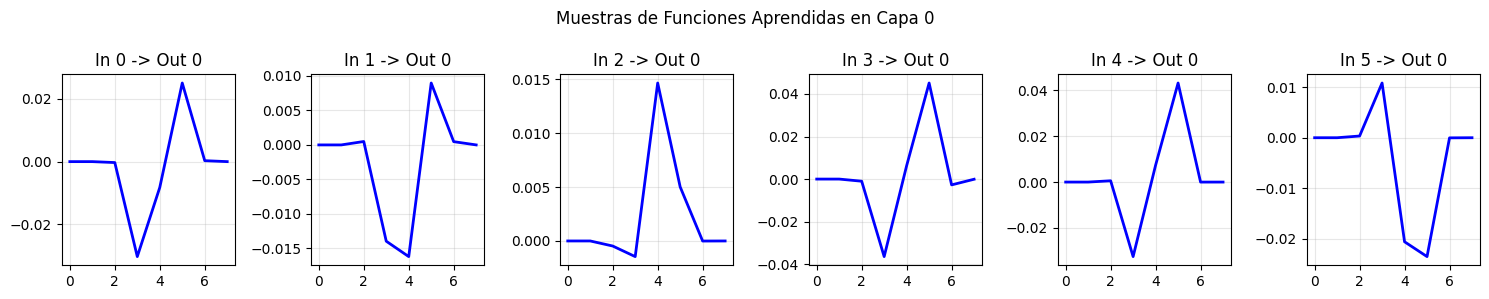

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kan_functions(model, layer_idx=0, n_examples=5):
    """
    Grafica las funciones de activación (splines) aprendidas por la capa.
    """
    kan_layers = [m for m in model.modules() if hasattr(m, "spline_weight")]
    layer = kan_layers[layer_idx]

    with torch.no_grad():
        # Tomamos los pesos y la base del grid
        weights = layer.spline_weight.cpu().numpy()
        # El grid suele estar definido en el módulo (depende de tu implementación)
        grid = (
            layer.grid.cpu().numpy()
            if hasattr(layer, "grid")
            else np.linspace(-1, 1, weights.shape[-1])
        )

    fig, axes = plt.subplots(1, n_examples, figsize=(15, 3))
    plt.suptitle(f"Muestras de Funciones Aprendidas en Capa {layer_idx}")

    # Graficamos algunas funciones aleatorias que tengan peso significativo
    out_dim, in_dim, _ = weights.shape
    count = 0
    for i in range(out_dim):
        for j in range(in_dim):
            if count >= n_examples:
                break

            # Solo graficamos si la conexión no es casi cero
            if np.abs(weights[i, j]).sum() > 0.01:
                y = weights[
                    i, j, :
                ]  # Simplificación: mostramos los coeficientes como proxy de la curva
                axes[count].plot(y, color="blue", lw=2)
                axes[count].set_title(f"In {j} -> Out {i}")
                axes[count].grid(True, alpha=0.3)
                count += 1
        if count >= n_examples:
            break

    plt.tight_layout()
    plt.show()

# Ver qué formas tienen las funciones que el modelo aprendió
plot_kan_functions(model_ft, layer_idx=0, n_examples=6)

Valor Máximo de Importancia: 0.408592
Valor Mínimo de Importancia: 0.009346


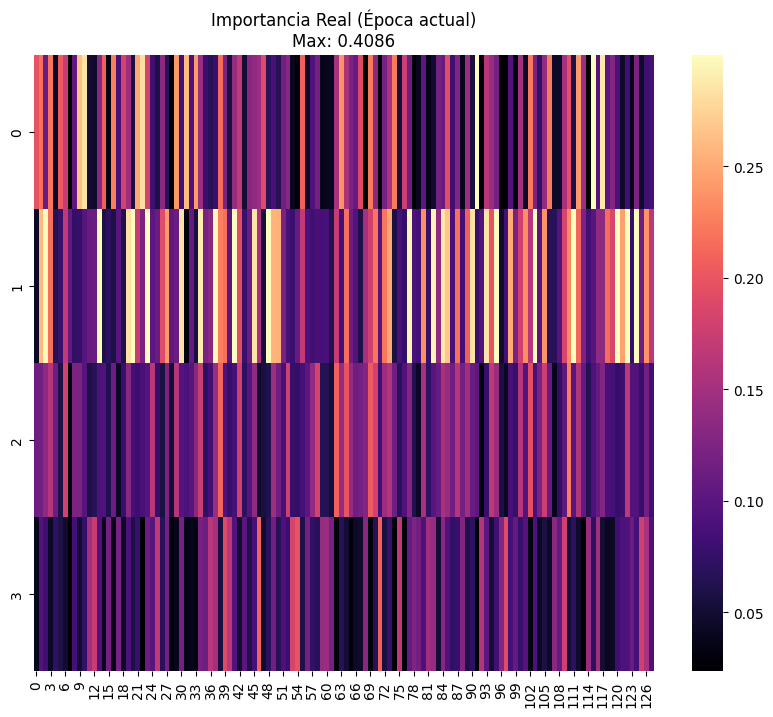

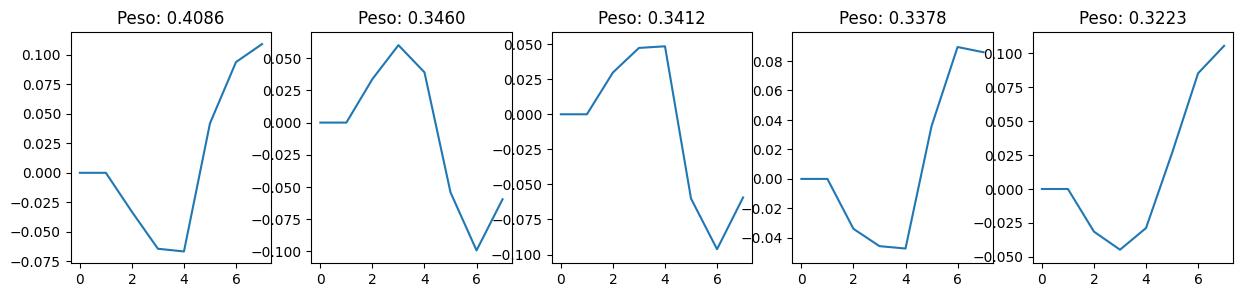

In [29]:
def visualize_kan_improved(model, layer_idx=0):
    kan_layers = [m for m in model.modules() if hasattr(m, "spline_weight")]
    layer = kan_layers[layer_idx]

    with torch.no_grad():
        # Obtenemos los pesos
        weights = layer.spline_weight.cpu()
        importance = torch.norm(weights, p=1, dim=-1).numpy()

        # LOG DE CONTROL: ¿Qué tan grandes son realmente los pesos?
        print(f"Valor Máximo de Importancia: {importance.max():.6f}")
        print(f"Valor Mínimo de Importancia: {importance.min():.6f}")

    plt.figure(figsize=(10, 8))
    # Usamos una escala robusta para el heatmap
    sns.heatmap(importance, cmap="magma", robust=True)
    plt.title(f"Importancia Real (Época actual)\nMax: {importance.max():.4f}")
    plt.show()

    # Para los splines, ajusta el eje Y al contenido real
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    out_dim, in_dim, _ = weights.shape
    # Graficar los 5 splines que tengan MÁS peso, no al azar
    flat_idx = importance.flatten().argsort()[-5:][::-1]

    for i, idx in enumerate(flat_idx):
        r, c = divmod(idx, in_dim)
        y = weights[r, c].numpy()
        axes[i].plot(y)
        axes[i].set_title(f"Peso: {importance[r,c]:.4f}")
        # AUTO-ESCALA: Muy importante para ver la forma
        axes[i].set_ylim(y.min() - 0.01, y.max() + 0.01)
    plt.show()


visualize_kan_improved(model_ft, layer_idx=2)

In [16]:
from torchsummary import summary

summary(model_ft, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 224, 224]        64
|    └─ReLU: 2-3                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-7                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 56, 56]          --
|    └─Conv2d: 2-9                       [-1, 128, 56, 56]         73,856
|    └─BatchNorm2d: 2-10                 [-1, 128, 56, 56]         256
|    └─ReLU: 2-11                        [-1, 128, 56, 56]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 28, 28]         --
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 224, 224]        64
|    └─ReLU: 2-3                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-7                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 56, 56]          --
|    └─Conv2d: 2-9                       [-1, 128, 56, 56]         73,856
|    └─BatchNorm2d: 2-10                 [-1, 128, 56, 56]         256
|    └─ReLU: 2-11                        [-1, 128, 56, 56]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 28, 28]         --
|   

Gráfica guardada en: models/sbtaylor_kan_cotton\run_20260105_193023\training_history.png


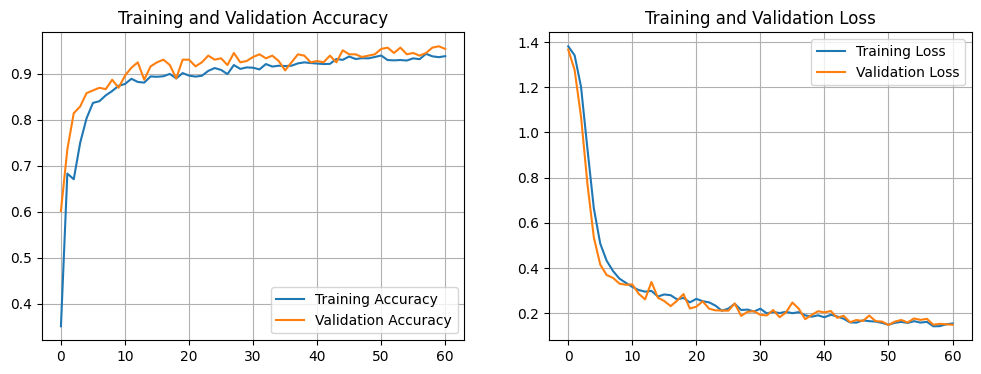

In [17]:
def plot_training_history(history):
    acc = history["train_acc"]
    val_acc = history["val_acc"]
    loss = history["train_loss"]
    val_loss = history["val_loss"]
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Gráfica de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    plt.grid(True)

    # Gráfica de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.grid(True)
    # --- CORRECCIÓN AQUÍ ---
    # 1. Guardar PRIMERO
    save_path = os.path.join(RUN_SAVE_DIR, "training_history.png")
    plt.savefig(
        save_path, dpi=300, bbox_inches="tight"
    )  # dpi=300 para alta calidad, bbox_inches corta bordes blancos extra
    print(f"Gráfica guardada en: {save_path}")

    # 2. Mostrar DESPUÉS
    plt.show()


plot_training_history(history)

In [18]:
import numpy as np
import time
import torch
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import logging  # Necesario para el type hinting o manejo interno


def evaluate_model(model, test_loader, device, class_names, output_dir, logger):
    """
    Evalúa un modelo entrenado y genera reporte.
    Ahora recibe 'logger' como argumento para asegurar que escriba en tu archivo .log.
    """
    logger.info("\n" + "=" * 40)
    logger.info("--- INICIANDO EVALUACIÓN EN TEST SET ---")
    logger.info("=" * 40)

    # 1. Poner el modelo en modo de evaluación (Apaga Dropout/BatchNorm)
    model.eval()

    all_labels = []
    all_preds = []

    total_inference_time = 0.0
    total_samples = 0

    # 2. Iterar sobre el conjunto de prueba
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # --- BLOQUE DE MEDICIÓN DE TIEMPO PRECISA ---
            # Si usas GPU, es obligatorio sincronizar antes y después del forward
            if device.type == "cuda":
                torch.cuda.synchronize()

            start_time = time.time()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            if device.type == "cuda":
                torch.cuda.synchronize()

            end_time = time.time()
            # ---------------------------------------------

            # Acumular tiempo real de procesamiento
            total_inference_time += end_time - start_time
            total_samples += inputs.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Convertir a numpy
    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_preds)

    # 3. Calcular Métricas
    logger.info("Calculando métricas estadísticas...")

    accuracy = accuracy_score(true_labels, predicted_labels)

    # zero_division=0 evita errores si una clase no tiene predicciones
    precision_per_class = precision_score(
        true_labels, predicted_labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        true_labels, predicted_labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        true_labels, predicted_labels, average=None, zero_division=0
    )

    # Promedios Macro (trata todas las clases igual, útil si hay desbalance)
    avg_precision = np.mean(precision_per_class)
    avg_recall = np.mean(recall_per_class)
    avg_f1 = np.mean(f1_per_class)

    # Tiempo promedio por imagen (Métrica Clave para KAN vs VGG)
    avg_inference_time_ms = (total_inference_time / total_samples) * 1000

    # 4. Matriz de Confusión Visual
    logger.info("Generando matriz de confusión...")
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",  # 'd' es para enteros (decimal), mejor que 'g' para conteos
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicción del Modelo", fontsize=12)
    plt.ylabel("Realidad (Ground Truth)", fontsize=12)
    plt.title(f"Matriz de Confusión - Accuracy: {accuracy:.2%}", fontsize=14)

    cm_path = os.path.join(output_dir, "confusion_matrix.png")
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.close()  # Cierra la figura para liberar memoria
    logger.info(f"Gráfico guardado en: {cm_path}")

    # 5. Reporte de Texto
    logger.info("Escribiendo reporte final...")

    metrics_df = pd.DataFrame(
        {
            "Clase": class_names,
            "Precision": np.round(precision_per_class, 4),
            "Recall": np.round(recall_per_class, 4),
            "F1-Score": np.round(f1_per_class, 4),
        }
    )

    report_path = os.path.join(output_dir, "test_metrics_report.txt")

    with open(report_path, "w", encoding="utf-8") as f:
        f.write("=" * 50 + "\n")
        f.write(f" REPORTE DE EVALUACIÓN: {time.strftime('%Y-%m-%d %H:%M')}\n")
        f.write("=" * 50 + "\n\n")

        f.write(f"Métricas Globales:\n")
        f.write(f"- Accuracy:          {accuracy:.4f} ({accuracy:.2%})\n")
        f.write(f"- Macro Precision:   {avg_precision:.4f}\n")
        f.write(f"- Macro Recall:      {avg_recall:.4f}\n")
        f.write(f"- Macro F1-Score:    {avg_f1:.4f}\n\n")

        f.write("-" * 30 + "\n")
        f.write("EFICIENCIA (Velocidad)\n")
        f.write("-" * 30 + "\n")
        f.write(f"- Muestras totales:  {total_samples}\n")
        f.write(f"- Tiempo total:      {total_inference_time:.4f} seg\n")
        f.write(f"- Tiempo por imagen: {avg_inference_time_ms:.4f} ms\n\n")

        f.write("-" * 30 + "\n")
        f.write("DETALLE POR CLASE\n")
        f.write("-" * 30 + "\n")
        # Usamos to_markdown si pandas es reciente, sino to_string
        try:
            f.write(metrics_df.to_markdown(index=False))
        except:
            f.write(metrics_df.to_string(index=False))

        f.write("\n\n")
        f.write("Matriz de Confusión (Texto):\n")
        f.write(np.array2string(cm, separator=", "))

    logger.info(f"Reporte de texto guardado en: {report_path}")
    logger.info("--- EVALUACIÓN FINALIZADA ---")

    return (
        accuracy,
        avg_f1,
    )  # Retorna valores por si los necesitas en el script principal

In [19]:
test_dir = COTTON_PATH + "/test"  # <--- Ruta a la carpeta de prueba
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_val)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)

In [20]:
MODEL_SAVE_PATH = os.path.join(RUN_SAVE_DIR, "best_model.pth")
# 2. Crear una nueva instancia del modelo y cargar los mejores pesos
logger.info("Cargando el mejor modelo para la evaluación...")
eval_model = KAN_Model(num_classes=num_classes_cotton).to(device)
eval_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
class_names = (
    test_dataset.classes
)  # Obtener los nombres de las clases desde el dataset de prueba
class_names

2026-01-05 20:50:37,570 - INFO - Cargando el mejor modelo para la evaluación...


Nueva dimensión para FC1 (con GAP): 128


['Curl Virus', 'Fresh_Leaf', 'Leaf_Reddening', 'Leaf_Spot_Bacterial_Blight']

In [21]:
# 3. Llamar a la función de evaluación
# Suponiendo que tienes un 'test_loader' y un 'RUN_DIR' definidos
evaluate_model(
    model=eval_model,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    output_dir=RUN_SAVE_DIR,  # El directorio de la ejecución actual para guardar los resultados
    logger=logger,
)

2026-01-05 20:50:37,655 - INFO - 
2026-01-05 20:50:37,656 - INFO - --- INICIANDO EVALUACIÓN EN TEST SET ---
2026-01-05 20:50:37,658 - INFO - ========================================
2026-01-05 20:50:44,012 - INFO - Calculando métricas estadísticas...
2026-01-05 20:50:44,018 - INFO - Generando matriz de confusión...
2026-01-05 20:50:44,233 - INFO - Gráfico guardado en: models/sbtaylor_kan_cotton\run_20260105_193023\confusion_matrix.png
2026-01-05 20:50:44,234 - INFO - Escribiendo reporte final...
2026-01-05 20:50:44,243 - INFO - Reporte de texto guardado en: models/sbtaylor_kan_cotton\run_20260105_193023\test_metrics_report.txt
2026-01-05 20:50:44,244 - INFO - --- EVALUACIÓN FINALIZADA ---


(0.9479768786127167, np.float64(0.9473573704543126))